In [202]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.signal import deconvolve
import holidays
from analysis import *

In [203]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)

Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0

Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric = Electric[['Date', 'Seconds', 'Load']]
Electric['Day'] = Electric['Date'].dt.day_name()
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

poland_holidays = holidays.CountryHoliday('Poland')
Electric['Holiday'] = Electric.Date.apply(lambda x: x in poland_holidays)
Electric.loc[Electric.Day.isin(['Sunday']) ,'Holiday'] = True

In [204]:
import emd
from scipy import ndimage

In [205]:
# Run a mask sift
imf = emd.sift.mask_sift(Electric.Load.to_numpy(), max_imfs=17) #, nprocesses=6)

In [41]:
np.unique(imf.sum(axis=1) == Electric.Load, return_counts=True)

(array([False,  True]), array([ 68805, 246843], dtype=int64))

In [44]:
68805/Electric.Load.shape[0], 246843/Electric.Load.shape[0]

(0.21798015510948904, 0.7820198448905109)

No handles with labels found to put in legend.


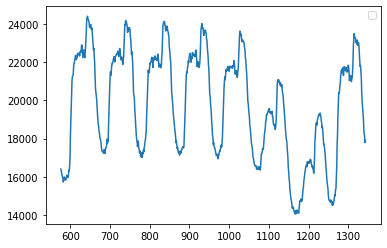

In [164]:
# Sottrarre solo la parte angolare del fit lineare ha come effetto di
# scorrelare (non completamente) le 3 distribuzioni visibili nel'istogramma
# per la deconvoluzione  

m, q = np.polyfit(x=Electric.index, y=Electric.Load, deg=1)
load_lin = m * Electric.index + q

Electric['Load_detrend'] = Electric.Load - load_lin

#plt.plot(Electric.Load - load_lin, label='load detrended')
#plt.plot(load_lin - q, label='lin (without q)')
plt.legend()

plt.plot(Electric.Load[96*7-96:96*14])

(70080.0, 331429.35)

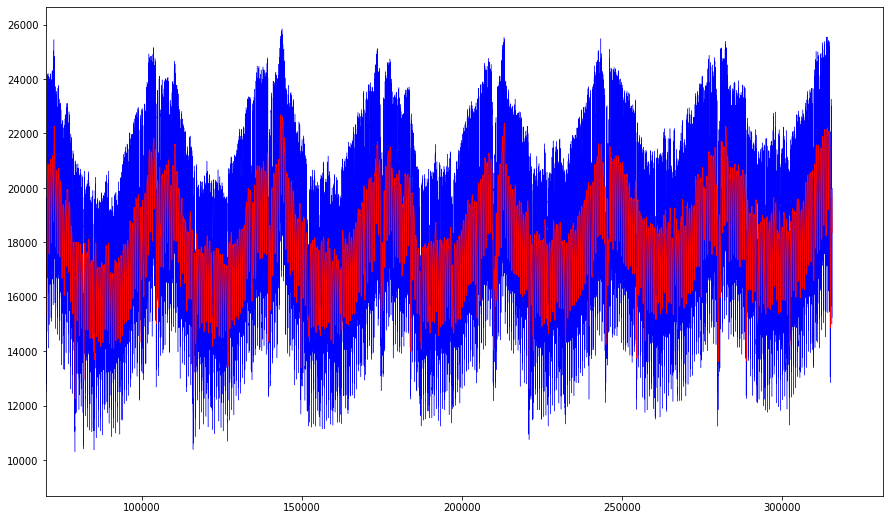

In [245]:
plt.figure(figsize=(15, 9))

t = Electric.Seconds.to_numpy()
t = np.column_stack(([t]*8))
ampl = 5e2
signal_rec1 = ampl * np.cos(t / (periods_filt * 3600 * 24)).sum(axis=1)
signal_rec2 = ampl * np.sin(t / (periods_filt * 3600 * 24)).sum(axis=1)

#series_imf_mask = pd.Series(imf[:, mask].sum(axis=1))
moving_avg = Electric.Load.rolling(96*2, min_periods=1).mean()

plt.plot(Electric.Load, lw=0.4, color='b')
plt.plot(moving_avg, lw=0.8, color='r')
#plt.plot(signal_rec2, lw=0.8, color='r')
plt.xlim(96 * 365*2)

(0.0, 100.0)

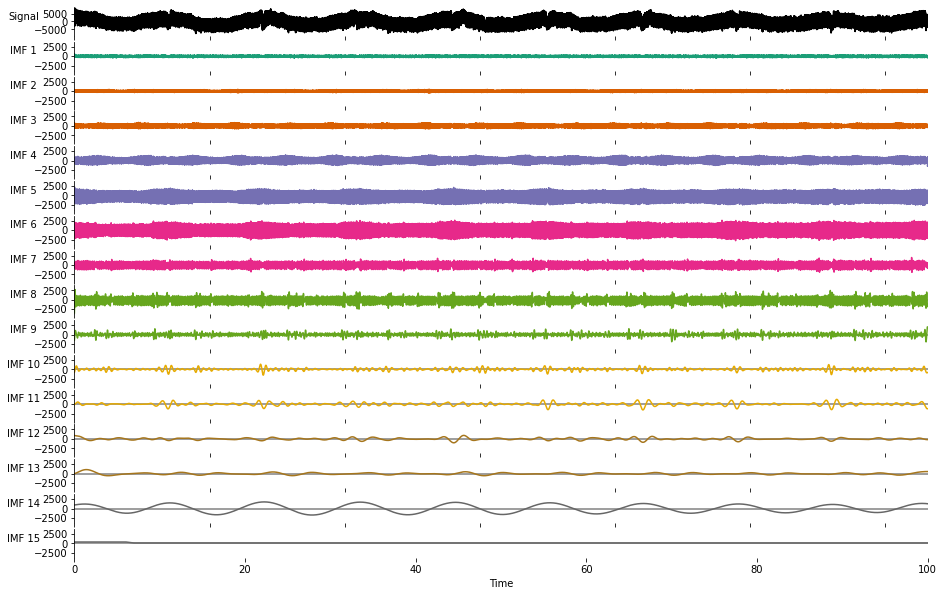

In [206]:
# Visualise the IMFs
sample_rate = 2048*1
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_imfs(imf[:, :15], cmap=True, scale_y=True, fig=fig)
plt.xlim(0, 100)

In [207]:
# Extract frequency information
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

In [208]:
def imf_frequencies(imfs: np.ndarray) -> np.ndarray:
    freqs = np.zeros(imfs.shape[1])
    rows = imfs.shape[0]
    # 15 minutes in seconds
    dt = 900
    f = np.linspace(0, 1/(2*dt), rows//2, endpoint=True)
    f = f[:len(f)//2]
    
    for i in range(imfs.shape[1]):      
        F = np.fft.fft(imfs[:, i])
        F_abs = np.abs(F)[:len(f)]
        freqs[i] = f[F_abs.argmax()]
    return freqs

freqs = imf_frequencies(imf)
# periods in days
periods = 1. / (freqs * 60 * 60 * 24)

<ipython-input-208-8bc754a852c3>:17: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1. / (freqs * 60 * 60 * 24)


In [235]:
periods[6:]

array([   3.50157526,    6.99570035,    6.99570035,   26.09507275,
         45.66637731,  121.77700617,  182.66550926,  365.33101852,
        657.59583333, 3287.97916667,           inf])

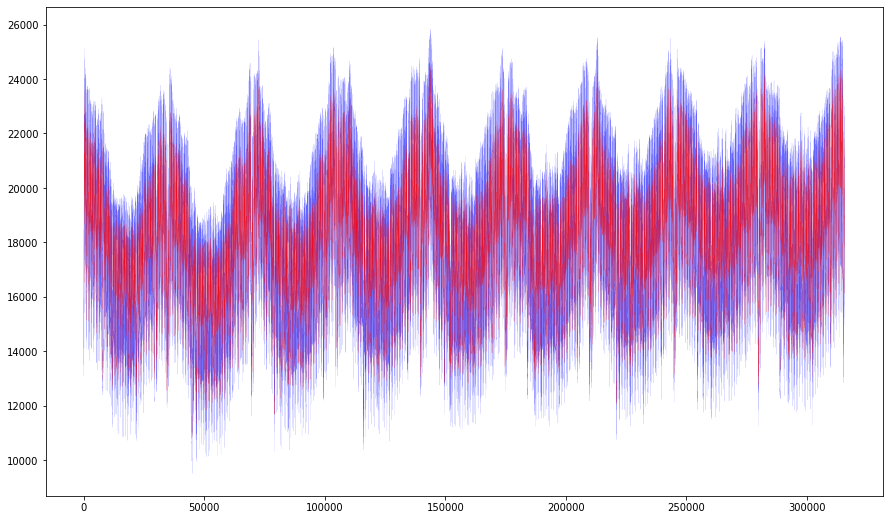

In [242]:
plt.figure(figsize=(15, 9))

signal_rec = imf[:, 5:].sum(axis=1)
plt.plot(Electric.Load, lw=0.1, color='b', alpha=0.6)
plt.plot(signal_rec, lw=0.1, color='r')

In [56]:
mask = (periods >= 6) & (periods < 1e3)
periods_filt = periods[mask]



array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False])

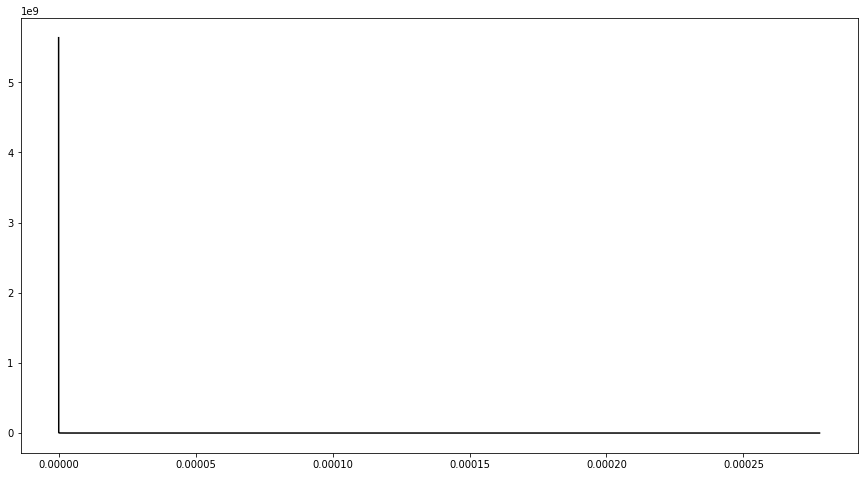

In [20]:
F = np.fft.fft(imf[:, 16])

dt = 900

f = np.linspace(0, 1/(2*dt), imf.shape[0]//2, endpoint=True)
F_abs = np.abs(F)[:len(f)//2]
f = f[:len(f)//2]

freq = np.fft.fftfreq(n=imf.shape[0], d=1/dt)

plt.figure(figsize=(15,8))
#plt.plot(freq[:len(freq)//2], np.abs(F[:len(freq)//2]), c='k', label="Real part")
plt.plot(f, F_abs, c='k', label="Real part")

In [7]:
1/(f[F_abs.argmax()]*60*60*24), f[F_abs.argmax()]

(365.33101851851853, 3.168106042845466e-08)

In [116]:
#Electric.loc[Electric.Day == 'Saturday', 'Holiday'] = True

Electric

,Date,Seconds,Load,Day,Minutes,Hour,Holiday
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0,True
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0,True
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0,True
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1,True
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1,True
...,...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23,False
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23,False
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23,False
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23,False


In [5]:
cutting_day = '2014-12-30'
train_set = Electric[Electric.Date <= pd.to_datetime(cutting_day, format='%Y-%m-%d')]
test_set = Electric[Electric.Date >= pd.to_datetime(cutting_day, format='%Y-%m-%d')]

In [118]:
def psf_forecasting(df, feature, wavelet='sym4', thr=0.04):
    
    if feature == 'load_denoised':    
        df[feature] = wavelet_filter(df['Load_detrend'].to_numpy(), 
                                     wavelet=wavelet,
                                     threshold=thr)
    else:
        pass

    f = {feature: ['mean', 'std']}
    psfs = df.groupby(['Hour',
                       'Minutes']).agg(f).reset_index()[feature].to_numpy()

    psf = psfs[:, 0]
    psf_up = psf + 1.96 * psfs[:, 1]
    psf_low = psf - 1.96 * psfs[:, 1]

    load = df[feature].to_numpy()
    deconv_psf = deconvolution(load, psf)
    deconv_psfup = deconvolution(load, psf_up)
    deconv_psflow = deconvolution(load, psf_low)

    load_psf = np.convolve(deconv_psf, psf, 'valid')[:-96]
    load_up = np.convolve(deconv_psfup, psf_up, 'valid')[:-96]
    load_low = np.convolve(deconv_psflow, psf_low, 'valid')[:-96]
    
    #plt.plot(psf)
    plt.plot(deconv_psf[:96*14])
    return deconv_psf, psf

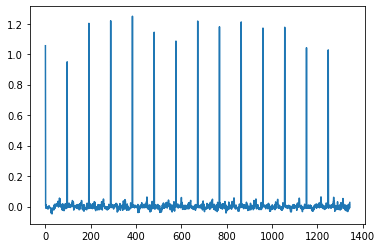

In [119]:
deconv, psf = psf_forecasting(Electric, 'Load_detrend')

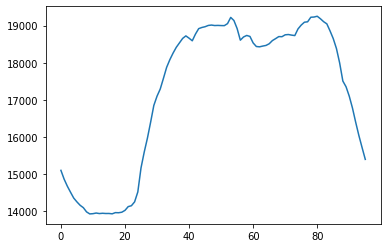

In [121]:
plt.plot(psf)

In [120]:
deconv[deconv < 0.2] = 0

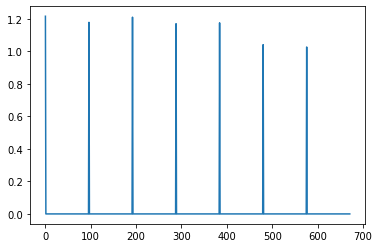

In [122]:
plt.plot(deconv[96*7:96*14])
#plt.plot(Electric.Date[:96*14], Electric.Load[:96*14])

In [124]:
Electric['deconv'] = deconv

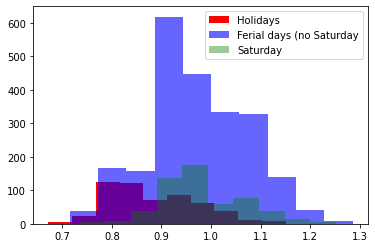

In [134]:
mask1 = Electric.deconv > 0
mask2 = Electric.Day != 'Saturday' 
plt.hist(Electric[(Electric.Holiday == True) & mask1].deconv, color='r', label='Holidays')
plt.hist(Electric[(Electric.Holiday == False) & mask1 & mask2].deconv, color='b',
         alpha=0.6, label='Ferial days (no Saturday')
plt.hist(Electric[(Electric.Holiday == False) & (Electric.Day == 'Saturday') & mask1].deconv, color='g'
         , alpha=0.4, label='Saturday')
plt.legend()

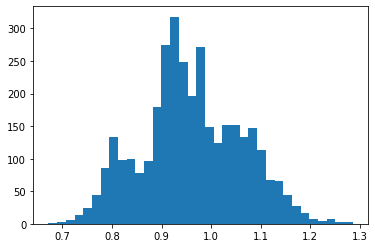

In [135]:
plt.hist(deconv[deconv > 0], bins='auto');

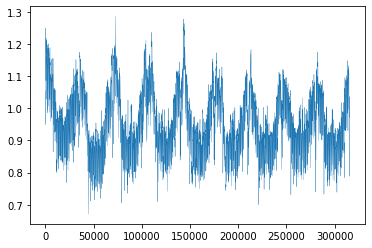

In [154]:
plt.plot(Electric.loc[mask1, 'deconv'], lw=0.3)

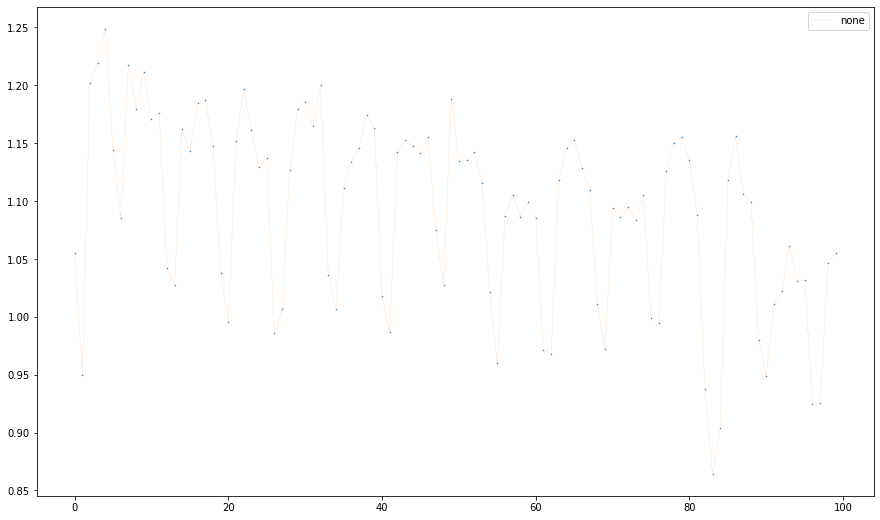

In [178]:
from scipy.interpolate import CubicSpline

y = Electric[mask1].deconv.to_numpy()[:100]
n = len(y)

cs = CubicSpline(x=range(n), y=y)
xs = np.arange(0, n)

plt.figure(figsize=(15, 9))
plt.plot(range(n), y, '.', markersize=1)
plt.plot(cs(xs, extrapolate='periodic'), lw=0.1, label='none')
#plt.plot(cs(xs, 1), lw=0.1, label='coeff=1')
#plt.plot(cs(xs, 2), lw=0.1, label='coeff=2')
plt.legend()

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = Electric.copy()
df.set_index('Date')
df
#ts_dicomposition = seasonal_decompose(x=Electric.Load, model='additive')
#trend_estimate = ts_dicomposition.trend
#seasonal_estimate = ts_dicomposition.seasonal
#residual_estimate = ts_dicomposition.resid

,Date,Seconds,Load,Day,Minutes,Hour,Holiday,Load_detrend,deconv
0,2008-01-01 00:15:00,0.0,15938.8,Tuesday,15,0,True,15938.800000,1.055256
1,2008-01-01 00:30:00,900.0,15770.4,Tuesday,30,0,True,15770.395045,0.000000
2,2008-01-01 00:45:00,1800.0,15766.3,Tuesday,45,0,True,15766.290090,0.000000
3,2008-01-01 01:00:00,2700.0,15415.2,Tuesday,0,1,True,15415.185135,0.000000
4,2008-01-01 01:15:00,3600.0,15351.8,Tuesday,15,1,True,15351.780179,0.000000
...,...,...,...,...,...,...,...,...,...
315643,2016-12-31 23:00:00,284078700.0,15952.7,Saturday,0,23,False,14388.645832,0.971670
315644,2016-12-31 23:15:00,284079600.0,15865.3,Saturday,15,23,False,14301.240877,0.971670
315645,2016-12-31 23:30:00,284080500.0,15693.5,Saturday,30,23,False,14129.435922,0.971670
315646,2016-12-31 23:45:00,284081400.0,15508.3,Saturday,45,23,False,13944.230967,0.971670
